In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fb_percentiles = pd.read_excel('/Users/harishprabhala/Downloads/martinchek-2012-2016-facebook-posts/fb_posts_percentiles.xlsx')

In [3]:
fb_percentiles['full_text'] = fb_percentiles['name'].map(str) + ' ' + fb_percentiles['message'].map(str) + ' ' + fb_percentiles['description'].map(str)

In [4]:
fb_percentiles_copy = fb_percentiles[['full_text','likes_count','shares_count','likes_percentile','shares_percentile']]

In [5]:
fb_percentiles_copy.head()

,full_text,likes_count,shares_count,likes_percentile,shares_percentile
0,Chief Justice Roberts Responds to Judicial Eth...,61,12,0.056,0.098
1,"With Reservations, Obama Signs Act to Allow De...",120,171,0.224,0.751
2,Wishes For 2012 to Fall on Times Square Some p...,271,0,0.582,0.000
3,Mitt Romney Vows to Veto Dream Act if Presiden...,140,23,0.291,0.187
4,"NY Pharmacy Shootout Leaves Suspect, ATF Agent...",59,34,0.051,0.269


In [6]:
fb_percentiles_copy['likes_class'] = fb_percentiles_copy['likes_percentile'].apply(lambda x: '1' if x > 0.75 else '0') 

/Users/harishprabhala/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
fb_percentiles_copy.head()

,full_text,likes_count,shares_count,likes_percentile,shares_percentile,likes_class
0,Chief Justice Roberts Responds to Judicial Eth...,61,12,0.056,0.098,0
1,"With Reservations, Obama Signs Act to Allow De...",120,171,0.224,0.751,0
2,Wishes For 2012 to Fall on Times Square Some p...,271,0,0.582,0.000,0
3,Mitt Romney Vows to Veto Dream Act if Presiden...,140,23,0.291,0.187,0
4,"NY Pharmacy Shootout Leaves Suspect, ATF Agent...",59,34,0.051,0.269,0


In [8]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

/Users/harishprabhala/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import gensim.parsing.preprocessing as process

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harishprabhala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess (line):
    line = re.sub(r"http\S+", "", line)
    line = re.sub(r"Photos", "", line)
    line = re.sub(r"Timeline", "", line)
    line = re.sub(r"nan", "", line)
    line = re.sub(r"photo", "", line)
    line = line.lower()
    line = process.remove_stopwords(line)
    line = process.strip_numeric(line)
    line = process.strip_punctuation(line)
    line = process.strip_short(line)
    line = process.strip_multiple_whitespaces(line)
    tokens = sent_tokenize(line)
    stemmed = [w for w in tokens if lemmatizer.lemmatize(w)] 
    return ' '.join(stemmed)

In [13]:
text = []
for w in fb_percentiles_copy['full_text']:
    text.append(preprocess(w))

In [14]:
X,y = text, fb_percentiles_copy['likes_class']

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
vectorizer = CountVectorizer()
X_1 = vectorizer.fit_transform(X)

In [17]:
from sklearn.feature_selection import chi2

In [18]:
X_new = SelectKBest(chi2, k=28000).fit_transform(X_1, y)

In [19]:
from sklearn.cross_validation import StratifiedKFold

In [20]:
kf = StratifiedKFold(y,n_folds=5, shuffle=True)
for train, test in kf:
    X1_train, X1_test = X_new[train], X_new[test]
    Y1_train, Y1_test = y[train], y[test]

In [21]:
X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape

((402252, 28000), (100562, 28000), (402252,), (100562,))

In [22]:
from sklearn.linear_model import LogisticRegression

In [33]:
logit=LogisticRegression(C=10, class_weight='auto')
logit.fit(X1_train,Y1_train)
print ('Accuracy of test data: ',(accuracy_score(logit.predict(X1_test), Y1_test)))
print ('Accuracy of training data: ',(accuracy_score(logit.predict(X1_train), Y1_train)))
print("\n")
print ('Classification report summary of Logistic Regression')
print(classification_report(logit.predict(X1_test), Y1_test))

/Users/harishprabhala/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Accuracy of test data:  0.694288100873
Accuracy of training data:  0.724781977467


Classification report summary of Logistic Regression
             precision    recall  f1-score   support

          0       0.71      0.86      0.78     63086
          1       0.64      0.41      0.50     37476

avg / total       0.68      0.69      0.68    100562



In [23]:
from sklearn.metrics import precision_recall_fscore_support

In [28]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [29]:
y_true_auc = np.array(Y1_test).astype(int)
y_pred_auc = np.array(logit.predict(X1_test)).astype(int)

In [28]:
Logistic_auc = roc_auc_score(y_true_auc, y_pred_auc)
Logistic_auc

0.59235634433122242

In [32]:
print(precision_recall_fscore_support(y_true_auc, y_pred_auc,average='weighted'))

(0.74615561575850609, 0.77589944511843445, 0.73721594482787689, None)


In [29]:
probas2_ = logit.predict_proba(X1_test)[:,1]

In [30]:
fpr2,tpr2,_ = roc_curve(y_true_auc, probas2_)

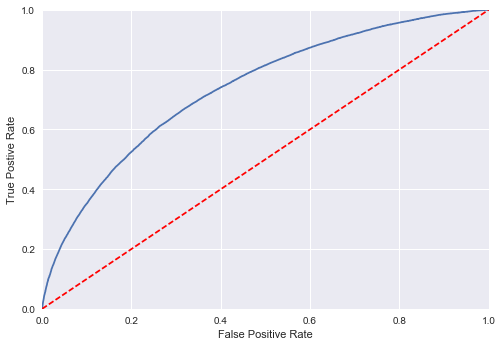

In [33]:
plt.plot(fpr2,tpr2, label=('Logistic %.2f' %Logistic_auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('True Postive Rate')
plt.xlabel('False Positive Rate')
plt.show()